In [ ]:
import os 
import openai as model
import gradio
import pandas as pd
import openai

In [ ]:
import hopsworks

project = hopsworks.login()
fs = project.get_feature_store()

In [ ]:
secrets = hopsworks.connection().get_secrets_api()
openai.api_key = secrets.get_secret("openai").value
org_id = "org-1u7PipOgiHmvwfH7N16VkhuJ"

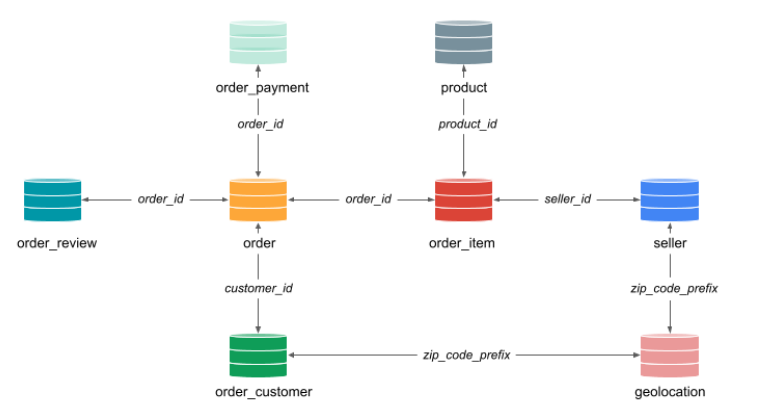

In [ ]:
feature_view = fs.get_feature_view("product_orders", version=1)
products_fv = fs.get_feature_view("products", version=1)


In [ ]:
df = feature_view.get_feature_vector(entry={"order_id" : "d7bd9020e0a2758aef0994ea533ee928", 
                                            "order_item_id": 1, 
                                            "product_id":"9ce4603565c839785b24a7e95e28f4eb"}, 
                                     allow_missing=True, 
                                     return_type="pandas")
df.to_string()
df

## Hopsworks RAG ChatBot

Two actions: __Send question__ and __Get recommendations__

### Send question

When clicking on Send question, the chatbot expects the question to be about the last orders of the user. For example, _Is there any cool stuff in my last order?_

In this case, the prompt is enhanced using the last order(s) information together with the user question, and sent to the LLM to generate an answer.

### Get product recommendations

When clicking on Get recommendations, the chatbot expects the question to contain preferences of the user. For example, _I really like cool stuff. Can you recommend me some original products?_

In this case, the following steps apply:
- An embedding is generated using the user question.
- This embedding is used to retrieve product candidates from OpenSearch
- The product ids are used to retrieve product information from the Online Feature Store.
- The details of the recommended products are added to the prompt
- The prompt is sent to the LLM to generate an answer.

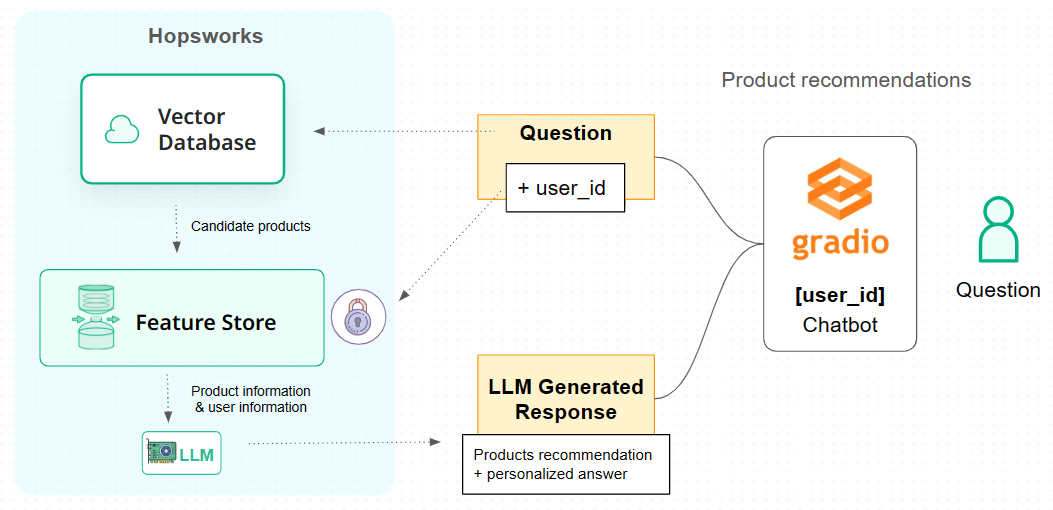

In [ ]:
prefix = df.to_string()

prompt = "Hi Javier. What's on your mind today?"
def api_calling(prompt):
    completions = model.Completion.create( 
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5, 
    ) 
    message = completions.choices[0].text
    return message 


def message_and_history(input, history):
    history = history or []
    s = list(sum(history, ())) 
    s.append(input) 
    inp = ' '.join(s)
    template = """The following is a table with the first row containing column names and the second row containing column values. 
    The table represents my order of a product. The details of my order are in the 2nd row. \n"""
    inp = template + prefix + "\n" + inp
    print(inp)
    output = api_calling(inp) 
    history.append((input, output)) 
    return history, history 


def recommendation_and_history(input, rec_history):
    rec_history = rec_history or []
    s = list(sum(rec_history, ())) 
    s.append(input)
    inp = ' '.join(s)
    template = """The following is a table with the product rows containing column names and values of each of the products.
    The table represents product recommendations for a user. Please, describe the product information as if you are recommending them to a user.\n"""
    prefix = ""
    inp = template + prefix + "\n" + inp
    print(inp)
    output = api_calling(inp) 
    rec_history.append((input, output)) 
    return rec_history, rec_history 

block = gradio.Blocks(theme=gradio.themes.Monochrome()) 
with block: 
    gradio.Markdown("""<h1><center> 
    Hopsworks RAG ChatBot</center></h1> 
    """) 
    chatbot = gradio.Chatbot() 
    message = gradio.Textbox(placeholder=prompt) 
    state = gradio.State() 
    submit_ask = gradio.Button("SEND QUESTION") 
    submit_rec = gradio.Button("GET RECOMMENDATIONS") 
    submit_ask.click(message_and_history,
                 inputs=[message, state],
                 outputs=[chatbot, state]) 
    submit_rec.click(recommendation_and_history,
                 inputs=[message, state],
                 outputs=[chatbot, state]) 
block.launch(debug = True, share=True)

In [ ]:
# Example of usage

# - I like cool stuff. Can you recommend me any original products?
# -> Get recommendations

# Is there any cool stuff in my last order?
# -> Send question.